# Data Processing 

## Import Required libraries and packages

In [1]:
# Install necessary packages
!pip install seaborn
!pip install sklearn

# Import libraries for data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import Spark SQL functions
from pyspark.sql.functions import col, from_unixtime, to_date, when, sum, count, log

# Import Spark MLlib features and models
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


## Read the transactions parquet file into a DataFrame: df

In [2]:
df = spark.read.parquet("/user/student/transactions")
df.show(5, truncate=False)

2024-09-16 14:53:46,067 WARN parquet.CorruptStatistics: Ignoring statistics because this file was created prior to 1.8.0, see PARQUET-251


+---+---------------------+----------------+----------------------------------+-------------+------+--------+-------+------+---------------------------+--------------+-----+-----+-------+--------+--------+------------------------------+-------------+--------------------------------+----------+---------+----------+--------+
|id |trans_date_trans_time|cc_num          |merchant                          |category     |amt   |first   |last   |gender|street                     |city          |state|zip  |lat    |lon     |city_pop|job                           |dob          |trans_num                       |unix_time |merch_lat|merch_long|is_fraud|
+---+---------------------+----------------+----------------------------------+-------------+------+--------+-------+------+---------------------------+--------------+-----+-----+-------+--------+--------+------------------------------+-------------+--------------------------------+----------+---------+----------+--------+
|1  |2019-01-01 00:00:18 

### Schema

In [3]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: float (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: float (nullable = true)
 |-- lon: float (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: long (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: float (nullable = true)
 |-- merch_long: float (nullable = true)
 |-- is_fraud: boolean (nullable = true)



## DataFrame Transformations

### dob column

In [3]:
# found dob column is long instead of date type
df.select("dob").show(5, truncate=False)

# Convert 'dob' from long to date and overwrite the 'dob' column
df = df.withColumn("dob", to_date(from_unixtime(col("dob") / 1000)))

# Show the updated DataFrame with the 'dob' column replaced
df.select("dob").show(5, truncate=False)

+-------------+
|dob          |
+-------------+
|573836400000 |
|-250938000000|
|-93776400000 |
|512319600000 |
|-269425800000|
+-------------+
only showing top 5 rows

+----------+
|dob       |
+----------+
|1988-03-09|
|1962-01-19|
|1967-01-12|
|1986-03-28|
|1961-06-19|
+----------+
only showing top 5 rows



### unix_time column

In [4]:
# found unix_time column is integer instead of timestamp type
df.select("unix_time").show(5, truncate=False)
# Convert 'unix_time' from integer (seconds) to timestamp
df = df.withColumn("unix_time", from_unixtime(col("unix_time")).cast("timestamp"))

# Show the updated DataFrame with the 'unix_time' column converted
df.select("unix_time").show(5, truncate=False)

+----------+
|unix_time |
+----------+
|1325376018|
|1325376051|
|1325376076|
|1325376186|
|1325376248|
+----------+
only showing top 5 rows

+-------------------+
|unix_time          |
+-------------------+
|2012-01-01 09:00:18|
|2012-01-01 09:00:51|
|2012-01-01 09:01:16|
|2012-01-01 09:03:06|
|2012-01-01 09:04:08|
+-------------------+
only showing top 5 rows



### is_fraud column

In [5]:
# found is_fraud column is boolean instead of integer type containing 0s and 1s
df.select("is_fraud").show(5, truncate=False)

# Convert 'is_fraud' from boolean to integer (0 and 1)
df = df.withColumn("is_fraud", when(col("is_fraud") == True, 1).otherwise(0))

# Show the updated DataFrame with the 'is_fraud' column replaced
df.select("is_fraud").show(5, truncate=False)

+--------+
|is_fraud|
+--------+
|false   |
|false   |
|false   |
|false   |
|false   |
+--------+
only showing top 5 rows

+--------+
|is_fraud|
+--------+
|0       |
|0       |
|0       |
|0       |
|0       |
+--------+
only showing top 5 rows



## From sparkDataFrame to pandas DataFrame

In [7]:
# Convert to Pandas DataFrame
pandas_df = df.limit(5).toPandas()

# Display as a table
print(pandas_df)

   id trans_date_trans_time            cc_num  \
0   1   2019-01-01 00:00:18  2703186189652095   
1   2   2019-01-01 00:00:51    38859492057661   
2   3   2019-01-01 00:01:16  3534093764340240   
3   4   2019-01-01 00:03:06   375534208663984   
4   5   2019-01-01 00:04:08  4767265376804500   

                             merchant       category         amt     first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.970000  Jennifer   
1                fraud_Lind-Buckridge  entertainment  220.110001    Edward   
2  fraud_Kutch, Hermiston and Farrell  gas_transport   45.000000    Jeremy   
3                 fraud_Keeling-Crist       misc_pos   41.959999     Tyler   
4    fraud_Stroman, Hudson and Erdman  gas_transport   94.629997  Jennifer   

      last gender                       street  ...        lat         lon  \
0    Banks      F               561 Perry Cove  ...  36.078800  -81.178101   
1  Sanchez      M     594 White Dale Suite 530  ...  42.180801 -112.262001   
2 

In [8]:
df.describe().show()

+-------+-----------------+---------------------+--------------------+-------------------+-------------+-----------------+-------+-------+-------+--------------------+-------+-------+------------------+------------------+------------------+-----------------+------------------+--------------------+-----------------+------------------+-------------------+
|summary|               id|trans_date_trans_time|              cc_num|           merchant|     category|              amt|  first|   last| gender|              street|   city|  state|               zip|               lat|               lon|         city_pop|               job|           trans_num|        merch_lat|        merch_long|           is_fraud|
+-------+-----------------+---------------------+--------------------+-------------------+-------------+-----------------+-------+-------+-------+--------------------+-------+-------+------------------+------------------+------------------+-----------------+------------------+-----------

## Data Cleaning

### Check for Nulls 

In [9]:

# Calculate null counts for each column
null_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])

# Collect the result as a dictionary
null_counts_dict = null_counts.collect()[0].asDict()

# Print column names and their null counts
for column, count in null_counts_dict.items():
    print(f"Column '{column}' has {count} null values.")

Column 'id' has 0 null values.
Column 'trans_date_trans_time' has 0 null values.
Column 'cc_num' has 0 null values.
Column 'merchant' has 0 null values.
Column 'category' has 0 null values.
Column 'amt' has 0 null values.
Column 'first' has 0 null values.
Column 'last' has 0 null values.
Column 'gender' has 0 null values.
Column 'street' has 0 null values.
Column 'city' has 0 null values.
Column 'state' has 0 null values.
Column 'zip' has 0 null values.
Column 'lat' has 0 null values.
Column 'lon' has 0 null values.
Column 'city_pop' has 0 null values.
Column 'job' has 0 null values.
Column 'dob' has 0 null values.
Column 'trans_num' has 0 null values.
Column 'unix_time' has 0 null values.
Column 'merch_lat' has 0 null values.
Column 'merch_long' has 0 null values.
Column 'is_fraud' has 0 null values.


### Check for Duplicates

In [10]:
# Create a DataFrame with a column for duplicate counts
duplicates_df = df.groupBy(df.columns).count().filter(col("count") > 1)

# Calculate the total number of duplicates for each column
duplicate_counts = {}
for column in df.columns:
    # Count duplicates by grouping on the column and counting occurrences
    count_duplicates = df.groupBy(column).count().filter(col("count") > 1).count()
    duplicate_counts[column] = count_duplicates

# Print the column names and their duplicate counts
for column, count in duplicate_counts.items():
    print(f"Column '{column}' has {count} duplicate values.")

Column 'id' has 0 duplicate values.
Column 'trans_date_trans_time' has 21573 duplicate values.
Column 'cc_num' has 983 duplicate values.
Column 'merchant' has 693 duplicate values.
Column 'category' has 14 duplicate values.
Column 'amt' has 31633 duplicate values.
Column 'first' has 352 duplicate values.
Column 'last' has 481 duplicate values.
Column 'gender' has 2 duplicate values.
Column 'street' has 983 duplicate values.
Column 'city' has 894 duplicate values.
Column 'state' has 51 duplicate values.
Column 'zip' has 970 duplicate values.
Column 'lat' has 968 duplicate values.
Column 'lon' has 969 duplicate values.
Column 'city_pop' has 879 duplicate values.
Column 'job' has 494 duplicate values.
Column 'dob' has 968 duplicate values.
Column 'trans_num' has 0 duplicate values.
Column 'unix_time' has 21543 duplicate values.
Column 'merch_lat' has 191945 duplicate values.
Column 'merch_long' has 272591 duplicate values.
Column 'is_fraud' has 2 duplicate values.


## Exploring Distributions

### Exploring Numeric Data with Box Plots

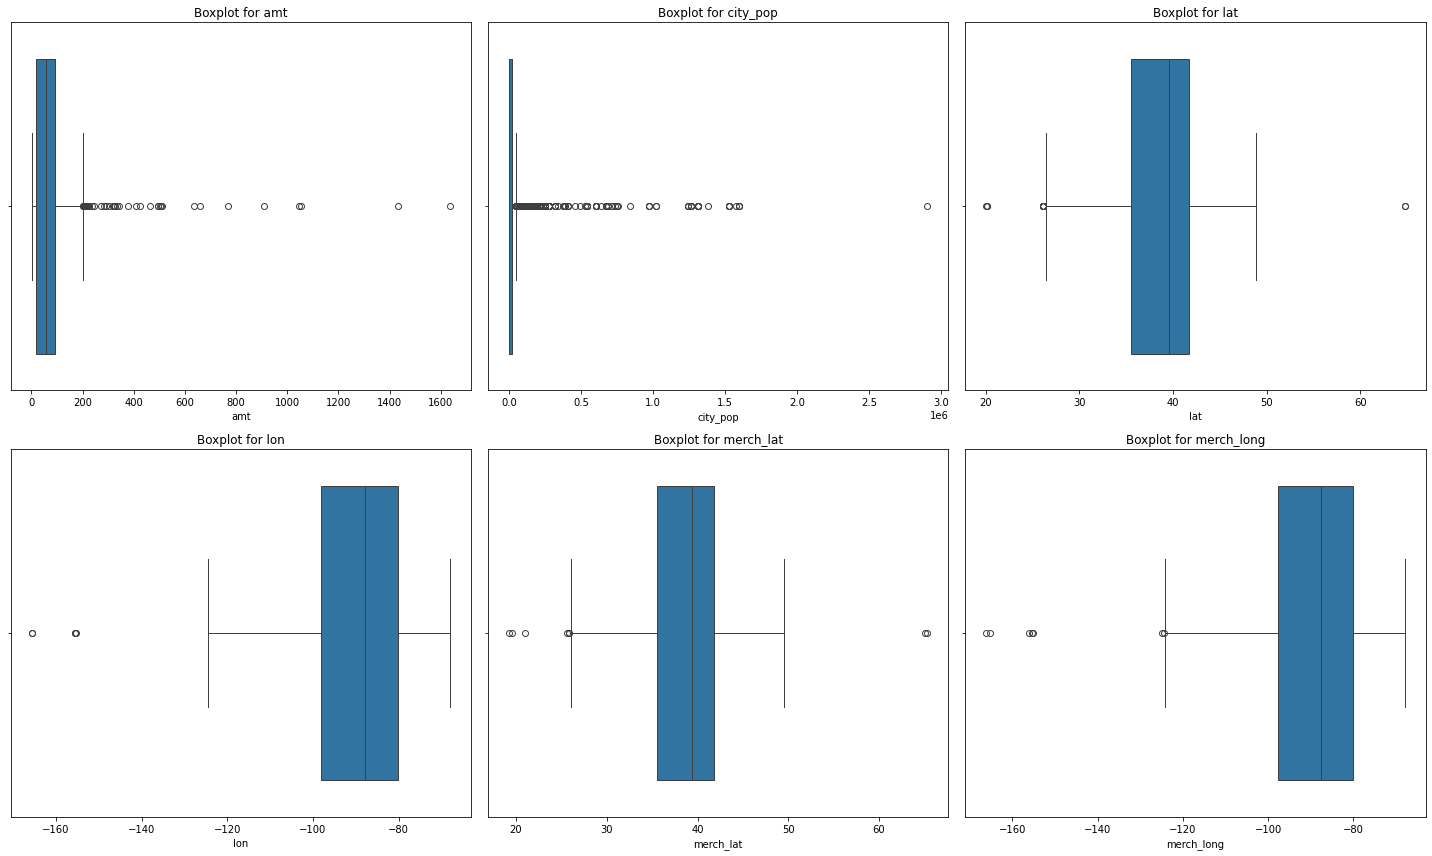

In [11]:
# Limit the data to a manageable size
pandas_df = df.limit(1000).toPandas()

# List of numeric columns to visualize
numeric_columns = ["amt", "city_pop", "lat", "lon", "merch_lat", "merch_long"]

# Set up a figure to hold multiple plots
plt.figure(figsize=(20, 12))

# Create a box plot for each numeric column to visualize outliers
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)  # Adjust the grid size according to the number of columns
    sns.boxplot(data=pandas_df, x=column)
    plt.title(f'Boxplot for {column}')

# Display the plots
plt.tight_layout()
plt.show()

# Querying

In [6]:
#Total Fraudulent Transactions by Merchant
df.filter(df.is_fraud == 1) \
  .groupBy("merchant") \
  .count() \
  .orderBy("count", ascending=False) \
  .show()


+--------------------+-----+
|            merchant|count|
+--------------------+-----+
|  fraud_Rau and Sons|   49|
|   fraud_Cormier LLC|   48|
|   fraud_Kozey-Boehm|   48|
|     fraud_Doyle Ltd|   47|
|fraud_Vandervort-...|   47|
|   fraud_Kilback LLC|   47|
| fraud_Padberg-Welch|   44|
|      fraud_Kuhn LLC|   44|
|    fraud_Terry-Huel|   43|
|      fraud_Jast Ltd|   42|
|   fraud_Goyette Inc|   42|
| fraud_Koepp-Witting|   42|
|fraud_Kiehn-Emmerich|   41|
|fraud_McDermott-W...|   41|
|fraud_Kerluke-Abs...|   41|
|fraud_Schmeler, B...|   41|
|fraud_Gleason-Mac...|   40|
|  fraud_Hudson-Ratke|   40|
|fraud_Murray-Smitham|   40|
|     fraud_Boyer PLC|   40|
+--------------------+-----+
only showing top 20 rows



In [7]:
#Top Cities by Number of Fraudulent Transactions
df.filter(df.is_fraud == 1) \
  .groupBy("city") \
  .count() \
  .orderBy("count", ascending=False) \
  .limit(10) \
  .show()


+-----------+-----+
|       city|count|
+-----------+-----+
|    Houston|   39|
|     Warren|   33|
|     Naples|   29|
| Huntsville|   29|
|     Dallas|   27|
|      Tulsa|   27|
|     Topeka|   27|
|    Detroit|   26|
|      Utica|   25|
|San Antonio|   25|
+-----------+-----+



In [8]:
#Fraudulent Transactions by Time of Day
from pyspark.sql.functions import hour

df.filter(df.is_fraud == True) \
  .withColumn("transaction_hour", hour("trans_date_trans_time")) \
  .groupBy("transaction_hour") \
  .count() \
  .orderBy("count", ascending=False) \
  .show()


+----------------+-----+
|transaction_hour|count|
+----------------+-----+
|              22| 1931|
|              23| 1904|
|               1|  658|
|               0|  635|
|               2|  625|
|               3|  609|
|              14|   86|
|              18|   81|
|              19|   81|
|              13|   80|
|              15|   79|
|              17|   78|
|              16|   76|
|              21|   74|
|              12|   67|
|              20|   62|
|               5|   60|
|               7|   56|
|               8|   49|
|               9|   47|
+----------------+-----+
only showing top 20 rows



In [9]:
#Average Transaction Amount for Fraudulent vs. Non-Fraudulent Transactions
df.groupBy("is_fraud") \
  .agg({"amt": "avg"}) \
  .withColumnRenamed("avg(amt)", "avg_transaction_amount") \
  .show()


+--------+----------------------+
|is_fraud|avg_transaction_amount|
+--------+----------------------+
|       1|     531.3200920353786|
|       0|      67.6670789134253|
+--------+----------------------+



In [10]:
#Fraud Rate by Category
from pyspark.sql.functions import sum as _sum

df.groupBy("category") \
  .agg((_sum(df.is_fraud.cast("int")) * 100 / _sum(df.is_fraud.cast("int") + (1 - df.is_fraud.cast("int")))).alias("fraud_rate")) \
  .orderBy("fraud_rate", ascending=False) \
  .show()


+--------------+-------------------+
|      category|         fraud_rate|
+--------------+-------------------+
|  shopping_net| 1.7561485703740913|
|      misc_net| 1.4457945549638946|
|   grocery_pos| 1.4097721555844933|
|  shopping_pos| 0.7225383982446517|
| gas_transport| 0.4693944204346076|
|      misc_pos| 0.3138534931893792|
|   grocery_net| 0.2948165097245446|
|        travel|0.28637025699261853|
| entertainment|0.24783542876592848|
| personal_care| 0.2424028735758831|
|     kids_pets|0.21143893484319015|
|   food_dining| 0.1650976919123998|
|          home|0.16082524468992407|
|health_fitness|0.15486905995645037|
+--------------+-------------------+



In [11]:
#Find the Most Common Job Among Fraudsters
df.filter(df.is_fraud == 1) \
  .groupBy("job") \
  .count() \
  .orderBy("count", ascending=False) \
  .limit(10) \
  .show()


+--------------------+-----+
|                 job|count|
+--------------------+-----+
|  Materials engineer|   62|
|Trading standards...|   56|
|     Naval architect|   53|
| Exhibition designer|   51|
|Surveyor, land/ge...|   50|
| Mechanical engineer|   49|
|   Quantity surveyor|   48|
|      Prison officer|   48|
|Audiological scie...|   46|
|Copywriter, adver...|   45|
+--------------------+-----+



### Visualizing Class Distribution with a Pie Chart

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   7506|
|       0|1289168|
+--------+-------+



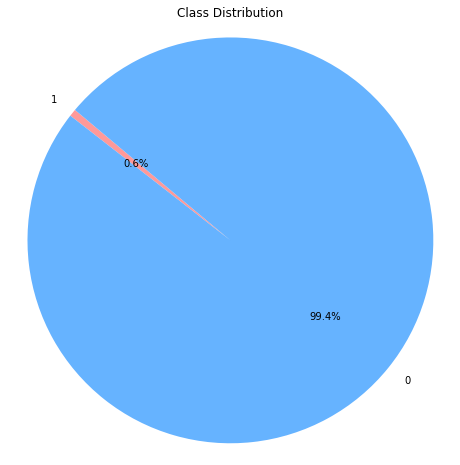

In [12]:
# Create a temporary view for SQL queries
df.createOrReplaceTempView("data_view")

# Define the target column
target_column = 'is_fraud'

# Query to count the occurrences of each class
class_counts = spark.sql(f"""
    SELECT {target_column}, COUNT(*) as count
    FROM data_view
    GROUP BY {target_column}
""")

class_counts.show()

# Convert Spark DataFrame to Pandas DataFrame
class_counts_pd = class_counts.toPandas()

# Prepare data for the pie chart
labels = class_counts_pd[target_column].astype(str)
sizes = class_counts_pd['count']
colors = ['#ff9999', '#66b3ff']  # Colors for the pie chart segments

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Show the pie chart
plt.show()

## Save DataFrame into Parquet and CSV file for next tasks

In [13]:
# Save the DataFrame as a Parquet file in HDFS
df.write.parquet("hdfs:///user/student/transactions_new/updated_fraud_data_parquet", mode="overwrite")
# Save the DataFrame as a CSV file in HDFS
df.write.csv("hdfs:///user/student/transactions_new/updated_fraud_data_csv", mode="overwrite", header=True)

## Preparations for machine learning

### Indexing and Encoding Categorical Data for Machine Learning

In [14]:
# Added a new column to calculate the transaction hour
transformed_df = df.withColumn("trans_hour", col("trans_date_trans_time").substr(12, 2).cast('int'))


# List of categorical columns
categorical_columns = ['merchant', 'category', 'gender', 'city', 'state', 'job']

# Index and encode categorical columns
indexers = []
encoders = []

for col_name in categorical_columns:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index")
    encoder = OneHotEncoder(inputCols=[col_name + "_index"], outputCols=[col_name + "_encoded"])
    
    indexers.append(indexer)
    encoders.append(encoder)
    
    transformed_df = indexer.fit(transformed_df).transform(transformed_df)
    transformed_df = encoder.fit(transformed_df).transform(transformed_df)

# Select feature columns, including encoded categorical features
feature_columns = ['amt', 'trans_hour', 'city_pop', 'lat', 'lon', 'merch_lat', 'merch_long'] \
    + [col + "_encoded" for col in categorical_columns]

# Apply VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
ml_data = assembler.transform(transformed_df)

# Show the resulting DataFrame with the "features" vector column
ml_data.select("features", *feature_columns).show(truncate=False)


2024-09-16 14:00:38,828 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+----------+--------+-------+--------+---------+----------+-----------------+----------------+--------------+-----------------+---------------+-----------------+
|features                                                                                                                                                                       |amt   |trans_hour|city_pop|lat    |lon     |merch_lat|merch_long|merchant_encoded |category_encoded|gender_encoded|city_encoded     |state_encoded  |job_encoded      |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+----------+--------+-------+--------+---------+----------+-----------------+----------------+--------------+-----------------+

### Splitting Data into Training and Testing Sets for Model Evaluation

In [15]:
target_column = 'is_fraud'
train_data, test_data = ml_data.randomSplit([0.5, 0.5])

## Training and Evaluating the Logistic Regression Model (for test purpose only)

In [16]:
# Initialize and train the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol=target_column)
lr_model = lr.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)

# Initialize evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="recallByLabel")
f1_evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="f1")

# Calculate metrics
accuracy = accuracy_evaluator.evaluate(lr_predictions)
precision = precision_evaluator.evaluate(lr_predictions)
recall = recall_evaluator.evaluate(lr_predictions)
f1_score = f1_evaluator.evaluate(lr_predictions)

# Print metrics
print(f"Logistic Regression Accuracy: {accuracy}")
print(f"Logistic Regression Precision: {precision}")
print(f"Logistic Regression Recall: {recall}")
print(f"Logistic Regression F1 Score: {f1_score}")

# Show a sample of predictions
lr_predictions.select("prediction", target_column, "features").show(10, truncate=False)

# Create and show the confusion matrix
confusion_matrix = lr_predictions.groupBy(target_column, "prediction").count()
confusion_matrix.show()

2024-09-16 14:01:48,927 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2024-09-16 14:01:48,928 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Logistic Regression Accuracy: 0.9948293101426376
Logistic Regression Precision: 0.995292866823365
Logistic Regression Recall: 0.9995266635835136
Logistic Regression F1 Score: 0.9933228641659783


+----------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|prediction|is_fraud|features                                                                                                                                                                     |
+----------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0.0       |0       |(2149,[0,2,3,4,5,6,326,705,1511,1651,2113],[220.11000061035156,4154.0,42.18080139160156,-112.26200103759766,43.150699615478516,-112.15399932861328,1.0,1.0,1.0,1.0,1.0])     |
|0.0       |0       |(2149,[0,2,3,4,5,6,526,709,985,1620,1953],[41.959999084472656,99.0,38.42070007324219,-79.46289825439453,38.67499923706055,-78.63249969482422,1.0,1.0,1.0,1.0,1.0])           |
|0.0       |0       

2024-09-16 14:03:53,465 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2024-09-16 14:03:53,649 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2024-09-16 14:03:53,708 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2024-09-16 14:03:54,019 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2024-09-16 14:03:57,346 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2024-09-16 14:03:57,412 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2024-09-16 14:03:57,584 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2024-09-16 14:03:57,967 WARN expressions.RowBasedKeyVal

+--------+----------+------+
|is_fraud|prediction| count|
+--------+----------+------+
|       1|       0.0|  3046|
|       0|       0.0|644057|
|       1|       1.0|   668|
|       0|       1.0|   305|
+--------+----------+------+



### Visualizing the Confusion Matrix for Model Performance

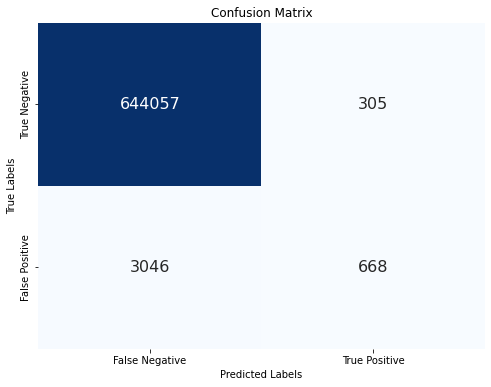

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert Spark DataFrame to Pandas DataFrame
predictions_and_labels = lr_predictions.select(col("prediction"), col(target_column)).rdd
prediction_df = predictions_and_labels.toDF(["prediction", "label"]).toPandas()

# Compute confusion matrix
conf_matrix = confusion_matrix(prediction_df["label"], prediction_df["prediction"])

# Create a DataFrame for visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=["True Negative", "False Positive"], columns=["False Negative", "True Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()